In [34]:
import numpy as np
import scipy.io as sio
from scipy.ndimage import gaussian_filter
from skimage import filters
#from skimage.filters import threshold_multiotsu
import sys
import cv2
from skimage.filters import threshold_otsu, threshold_multiotsu
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.sparse import csc_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
#!{sys.executable} -m pip install scikit-fmm==0.0.8 --user
import skfmm
from scipy.ndimage import gaussian_filter, morphology

    100% |████████████████████████████████| 276kB 2.2MB/s ta 0:00:01
  Stored in directory: /Users/kflq001/Library/Caches/pip/wheels/d8/4f/21/8592c551fa880abfceedaecfca1baa3dfaa3dc69093dd095eb
Successfully built scikit-fmm
  Found existing installation: scikit-fmm 0.0.9
    Uninstalling scikit-fmm-0.0.9:
      Successfully uninstalled scikit-fmm-0.0.9
You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [85]:
# HERE ARE SOME DEFAULT PARAMETERS FOR SEGMENTING A LUNG IN A CT.
# SET TYPE = GLOBAL FOR GLOBAL SEG AND TYPE = SELECTIVE FOR LOCAL SEG.
TYPE = "SELECTIVE"
#TYPE = "GLOBAL"

LOAD = sio.loadmat('TestFilesPython.mat')
z = np.array(LOAD['z'])
c1 = 0
c2 = 1
lambda1 = np.array(LOAD['lambda'])[0][0]
tau = np.array(LOAD['tau'])[0][0]
Iters = np.array(LOAD['Iters'])[0][0]
utol = 0.001 # np.array(LOAD['utol'])[0][0]
sigma1 = np.array(LOAD['sigma1'])[0][0]
lambda3 = np.array(LOAD['lambda3'])[0][0]
eps2 = np.array(LOAD['eps2'])[0][0]
w = np.array(LOAD['w'])
lambda_TV = np.array(LOAD['lambda_TV'])[0][0]
theta_tai = np.array(LOAD['theta_tai'])[0][0]
Mask = np.array(LOAD['Mask'])
rows = np.array(LOAD['rows'])
cols = np.array(LOAD['cols'])
SSF = np.array(LOAD['SSF'])
xi = 0.1

if TYPE == "SELECTIVE":
    
    theta = np.array(LOAD['theta'])[0][0]
    CV_type = 1
    
elif TYPE == "GLOBAL":
    
    theta = 0.001
    CV_type = 0

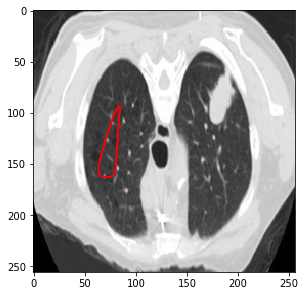

In [86]:
fig1, ax2 = plt.subplots(constrained_layout=True)
ax2.imshow(z,cmap='gray')
origin = 'lower'
CS2 = ax2.contour(Mask, levels=[0.1000,0.10001], colors='r', origin=origin)

In [94]:
from scipy.ndimage import gaussian_filter, morphology

def calculate_geodesic_dist(z, rows, cols):

    beta = 1000; 
    z_sm = gaussian_filter(z,sigma=1)
    gx, gy = np.gradient(z_sm);
    nab_z = np.sqrt(gx**2+gy**2);

    R = np.zeros(np.shape(nab_z));
    for i in range(np.shape(cols)[0]):
        R[rows[i],cols[i]] = 1; 

    BW = morphology.distance_transform_edt(1-R)

    D_E = BW/np.max(BW.flatten());

    f = (1.0e-3)*np.ones(np.shape(D_E)) + beta*nab_z**2 +xi*D_E;
    f = (f-np.min(f.flatten()))/(np.max(f.flatten())-np.min(f.flatten()))
    f = f + 0.01
    f = (1./f)+0.01

    T = skfmm.travel_time(Mask-0.5*np.ones(np.shape(Mask)), speed=f, dx=1.0/np.shape(Mask)[0], order=1)

    return T

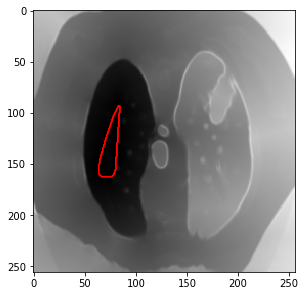

In [95]:
T = calculate_geodesic_dist(z, rows, cols)

fig1, ax2 = plt.subplots(constrained_layout=True)
ax2.imshow(T,cmap='gray')
origin = 'lower'
CS2 = ax2.contour(Mask, levels=[0.1000,0.10001], colors='r', origin=origin)